# w and b to predict top

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m', 'bh_pt', 'bh_eta', 'bh_phi', 'bh_m','bl_pt', 'bl_eta', 'bl_phi', 'bl_m']

t_keys = list(filter(lambda a: 't'==a[0], dataset.keys()))
b_keys = list(filter(lambda a: 'b'==a[0], dataset.keys()))
w_keys = list(filter(lambda a: 'w'==a[0], dataset.keys()))

phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  1000000

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'cart_pt', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'meanmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

t_names = list(filter(lambda a: a[0] == 't', Y_names))
w_names = list(filter(lambda a: a[0] == 'w', Y_names))
b_names = list(filter(lambda a: a[0] == 'b', Y_names))

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 3.410605131648481e-13


In [3]:
# Create X and test array
split = int(np.floor(0.9*crop0)) # 80/20 split 

Y_t, Y_w, Y_b = Y_total[:, 0:len(t_names)], Y_total[:, len(t_names):len(t_names)+len(w_names)], Y_total[:, len(t_names)+len(w_names):]
trainY_t, testY_t = Y_t[0:split,:], Y_t[split:,:]
trainY_w, testY_w = Y_w[0:split,:], Y_w[split:,:]
trainY_b, testY_b = Y_b[0:split,:], Y_b[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY_t.shape, trainY_w.shape, trainY_b.shape)
print(testX_jets.shape, testX_other.shape, testY_t.shape, testY_w.shape, testY_b.shape)

(900000, 6, 6) (900000, 7) (900000, 10) (900000, 10) (900000, 10)
(100000, 6, 6) (100000, 7) (100000, 10) (100000, 10) (100000, 10)


In [4]:
# Histograms of total  Y variables 
show = False

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-0.1, 0.1, 40)
pt_bins = np.linspace(-0.3, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*Y_total.shape[1]))
    for i in range(0, Y_total.shape[1]):
        plt.subplot(Y_total.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

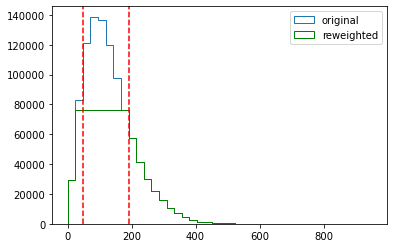

In [6]:
th_pt = np.array(dataset.get('th_pt'))[0:crop0]
hist1, bins = np.histogram(th_pt, 40)
hist1 = hist1 + (hist1<=0)*1
bins[-1] = np.inf
plt.hist(th_pt, 40, histtype='step', label='original')
argright = 8
argleft = 2
right = bins[argright]
left = bins[argleft]
compare_min = hist1[argright-1]
plt.axvline(x=left, color='r', linestyle='--')
plt.axvline(x=right, color='r', linestyle='--')
flat = 1
belong = np.digitize(th_pt, bins) - 1
factor = compare_min/hist1*(hist1>=compare_min) + (hist1<compare_min)
weight = factor[belong]
plt.hist(th_pt, bins, histtype='step', label='reweighted', color='g', weights=weight)
plt.legend()

In [7]:
# get total b predictions
w_model = keras.models.load_model('wtest.keras')
b_model = keras.models.load_model('predict_b.keras')

trainX_w, testX_w = w_model.predict([trainX_jets, trainX_other]), w_model.predict([testX_jets, testX_other])
trainX_b, testX_b = b_model.predict([trainX_jets, trainX_other]), b_model.predict([testX_jets, testX_other])
trainX_other_wb, testX_other_wb = np.concatenate([trainX_other, trainX_w, trainX_b], axis=1),  np.concatenate([testX_other, testX_w, testX_b], axis=1)

In [8]:
# build and train t model 

def build_tmodel():
    initializer = initializers.he_normal(seed=1)
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    
    other_input = Input(shape=(trainX_other_wb.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu',kernel_initializer=initializer)(concat0)
    PreDense2 = Dense(128, activation='relu',kernel_initializer=initializer)(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2) # 4 relevant jets
    Shape_Dot = Reshape((-1,1))(PreDense3)
    Dot_jets = Multiply()([Shape_Dot, Mask])
    
    TDDense11 = TimeDistributed(Dense(128, activation='relu',kernel_initializer=initializer))(Dot_jets)
    TDDense12 = TimeDistributed(Dense(128, activation='relu',kernel_initializer=initializer))(TDDense11)
    Sum = Flatten()(TDDense12)
    # Sum = Lambda(lambda x: tf.reduce_sum(x,1))(TDDense12)
    Dense13 = Dense(128, activation='relu',kernel_initializer=initializer)(Sum)
    flat_right = Flatten()(Dense13)
    
    Dense21 = Dense(128, activation='relu',kernel_initializer=initializer)(other_input)
    Dense22 = Dense(128, activation='relu',kernel_initializer=initializer)(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat1 = concatenate([flat_other, flat_right])
    dense1 = Dense(420, activation='relu',kernel_initializer=initializer)(concat1)
    dense2 = Dense(256, activation='relu',kernel_initializer=initializer)(dense1)
    output_t = Dense(len(t_names), activation='linear')(dense2)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output_t)
    optimizer = keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

model = build_tmodel()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
Epochs= 256
history = model.fit([trainX_jets, trainX_other_wb], trainY_t, verbose=1, epochs=Epochs, 
                   validation_data=([testX_jets, testX_other_wb], testY_t), shuffle=True, callbacks=[callback],
                    batch_size=1000)

Train on 900000 samples, validate on 100000 samples
Epoch 1/256
900000/900000 [==============================] - 7s 8us/sample - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 2/256
900000/900000 [==============================] - 6s 6us/sample - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 3/256
900000/900000 [==============================] - 6s 6us/sample - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 4/256
900000/900000 [==============================] - 6s 6us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 5/256
900000/900000 [==============================] - 6s 6us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 6/256
900000/900000 [==============================] - 6s 6us/sample - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 7/256
900000/900000 [==============================] - 6s 6us/sample - loss: 0.0036 - mse: 0.003

900000/900000 [==============================] - 6s 6us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 59/256
900000/900000 [==============================] - 6s 6us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 60/256
900000/900000 [==============================] - 6s 6us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0035 - val_mse: 0.0035


In [29]:
model.save('ttest.keras')

Text(0.5, 1.0, 'MSE loss')

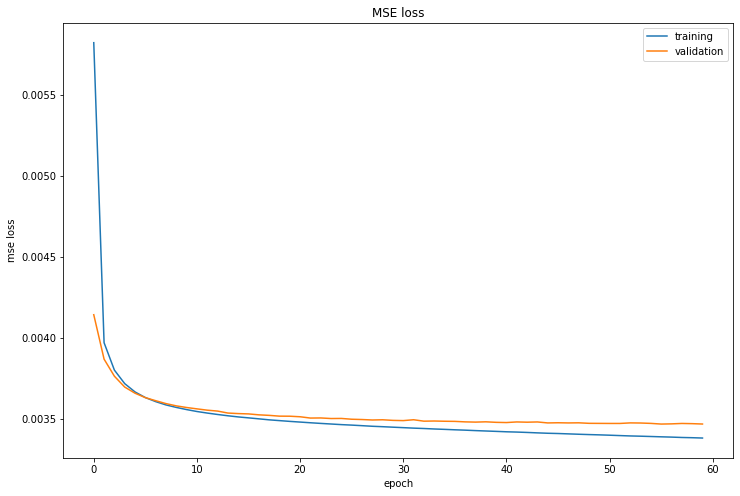

In [10]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [11]:
predictions_unscaled = model.predict([testX_jets, testX_other_wb])

true_unscaled = testY_t

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other_wb,testX_other_wb,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)
total_b_predictions = b_model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
total_w_predictions = w_model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])

predictions_origscale = Scaler.invscale_arrays(Y_keys, np.concatenate([total_predictions, total_w_predictions, total_b_predictions], axis=1), _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

# small_b, small_t = model.predict([testX_jets, testX_other_b])
# predictions_unscaled = np.concatenate([small_b, small_t], axis=1)

# true_unscaled = np.concatenate([testY_b, testY_t], axis=1)

# total_b, total_t = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other_b,testX_other_b,axis=0)])
# total_predictions = np.concatenate([total_b, total_t], axis=1)
# (Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

# predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
# true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

In [12]:
# np.save('true', predictions_origscale)
# np.save('pred', true_origscale)

# Training scale plots 

In [13]:
import analysis
import importlib
importlib.reload(analysis)
Analysis = analysis.Analysis 
Analysis.display_errors(predictions_unscaled, true_unscaled, t_names, False)

total MSE: 0.003468081725648719
 
th_ptbox MSE :  0.0022142386
th_px MSE :  0.0027391004
th_py MSE :  0.0043511732
th_eta MSE :  0.0062410836
th_m MSE :  0.0042592097
tl_ptbox MSE :  0.0017935293
tl_px MSE :  0.0032131349
tl_py MSE :  0.0020612421
tl_eta MSE :  0.0032293555
tl_m MSE :  0.0045787501


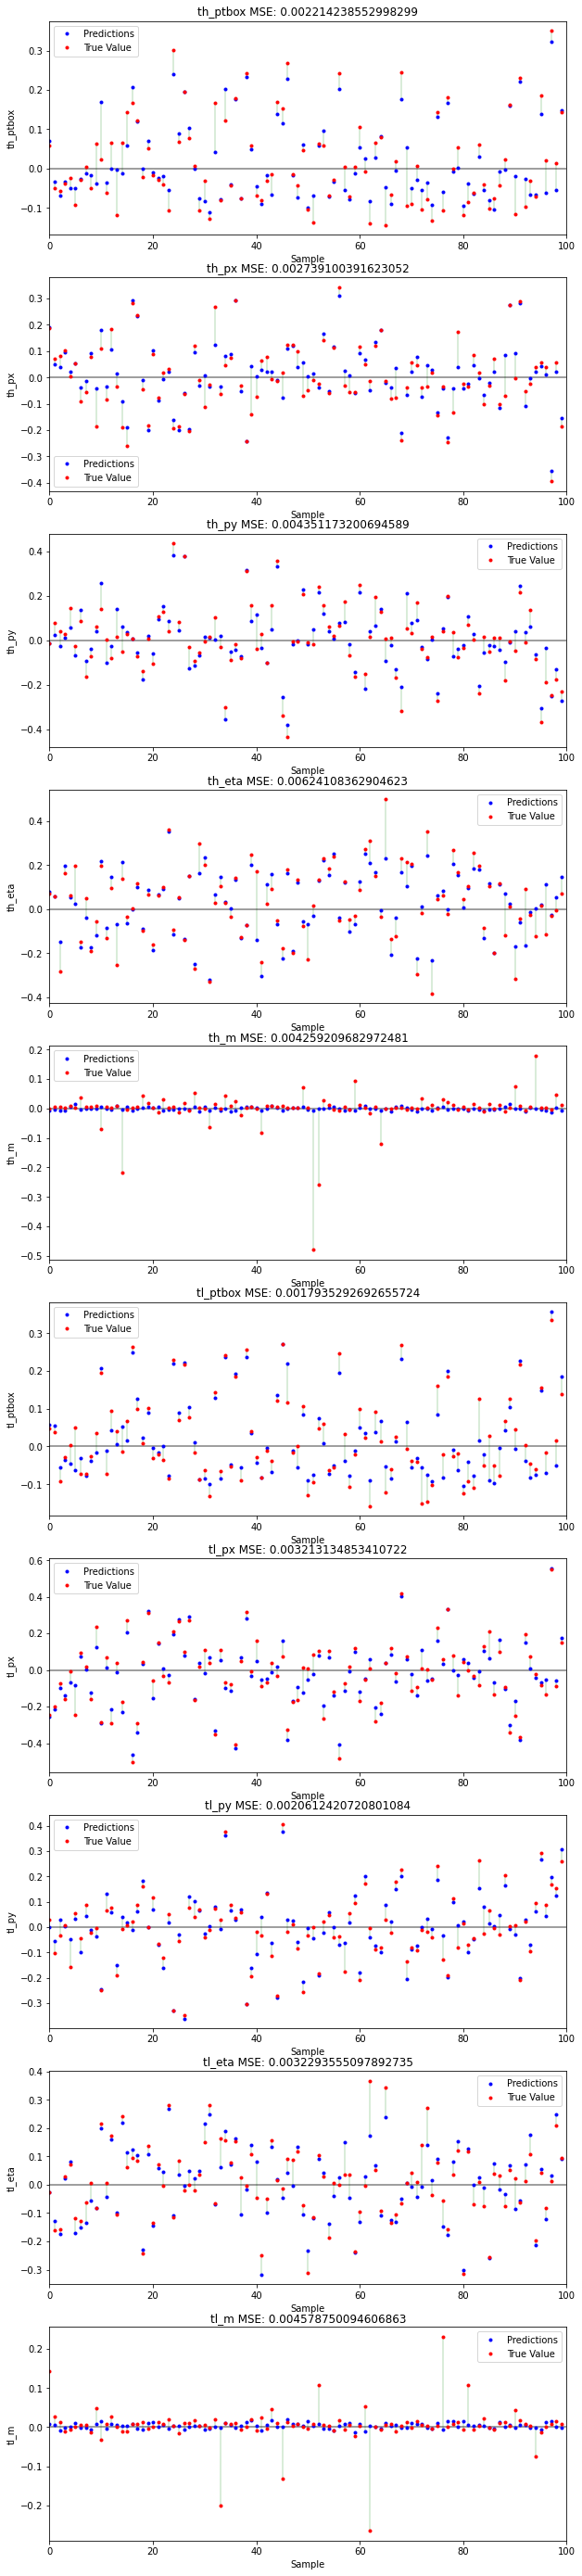

In [14]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, t_names, False)

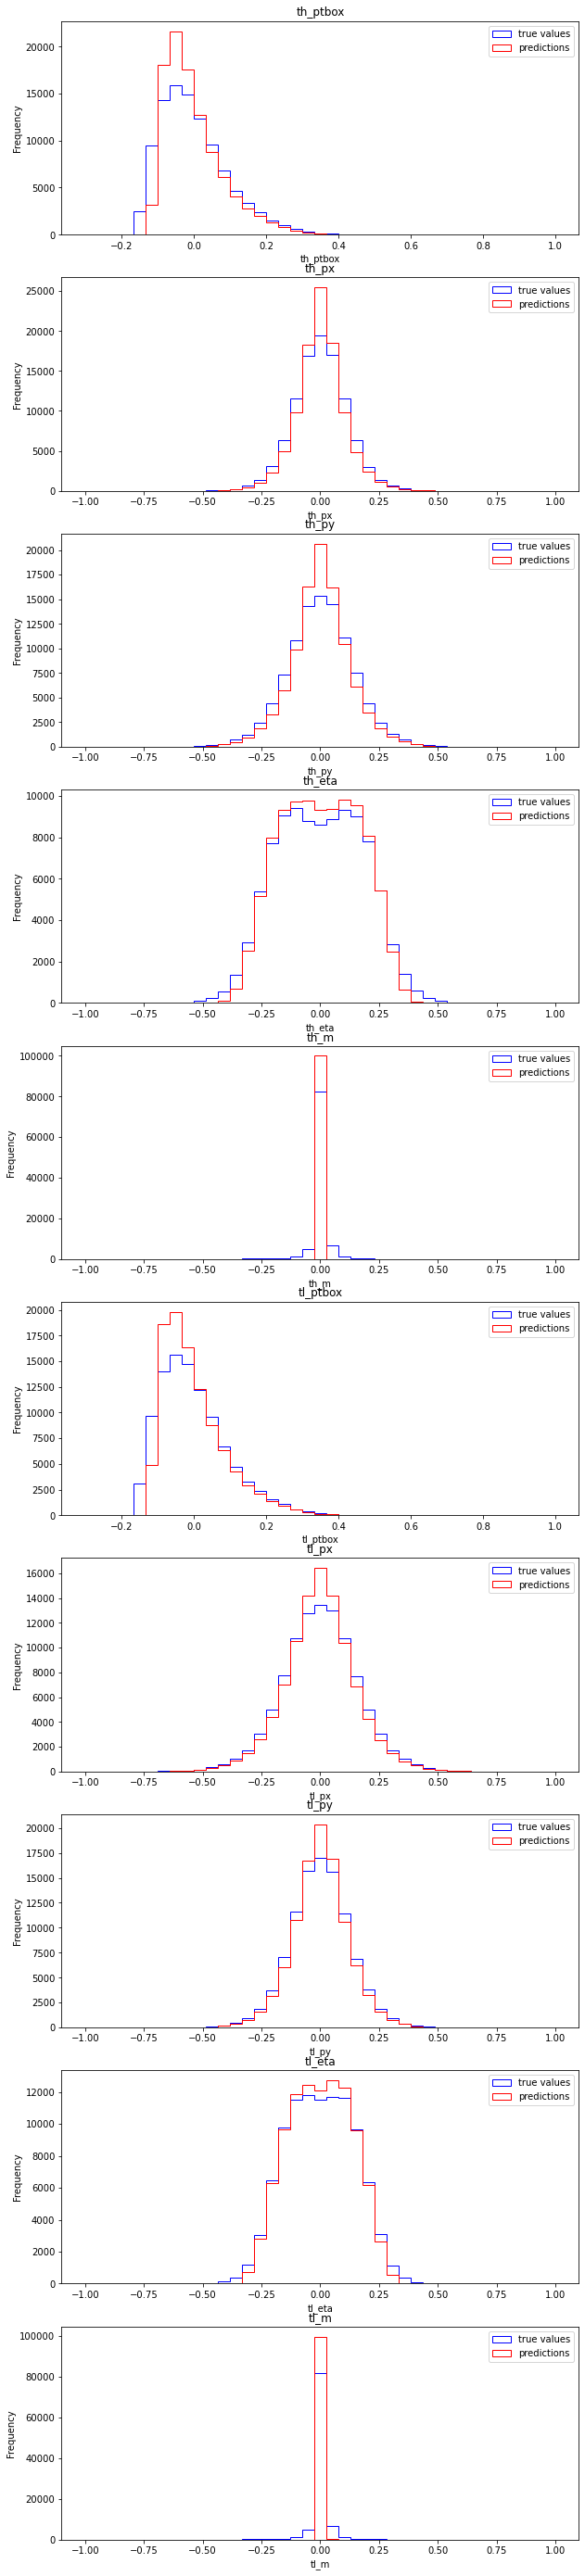

In [15]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, t_names, False, Y_bins)

In [16]:
# Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

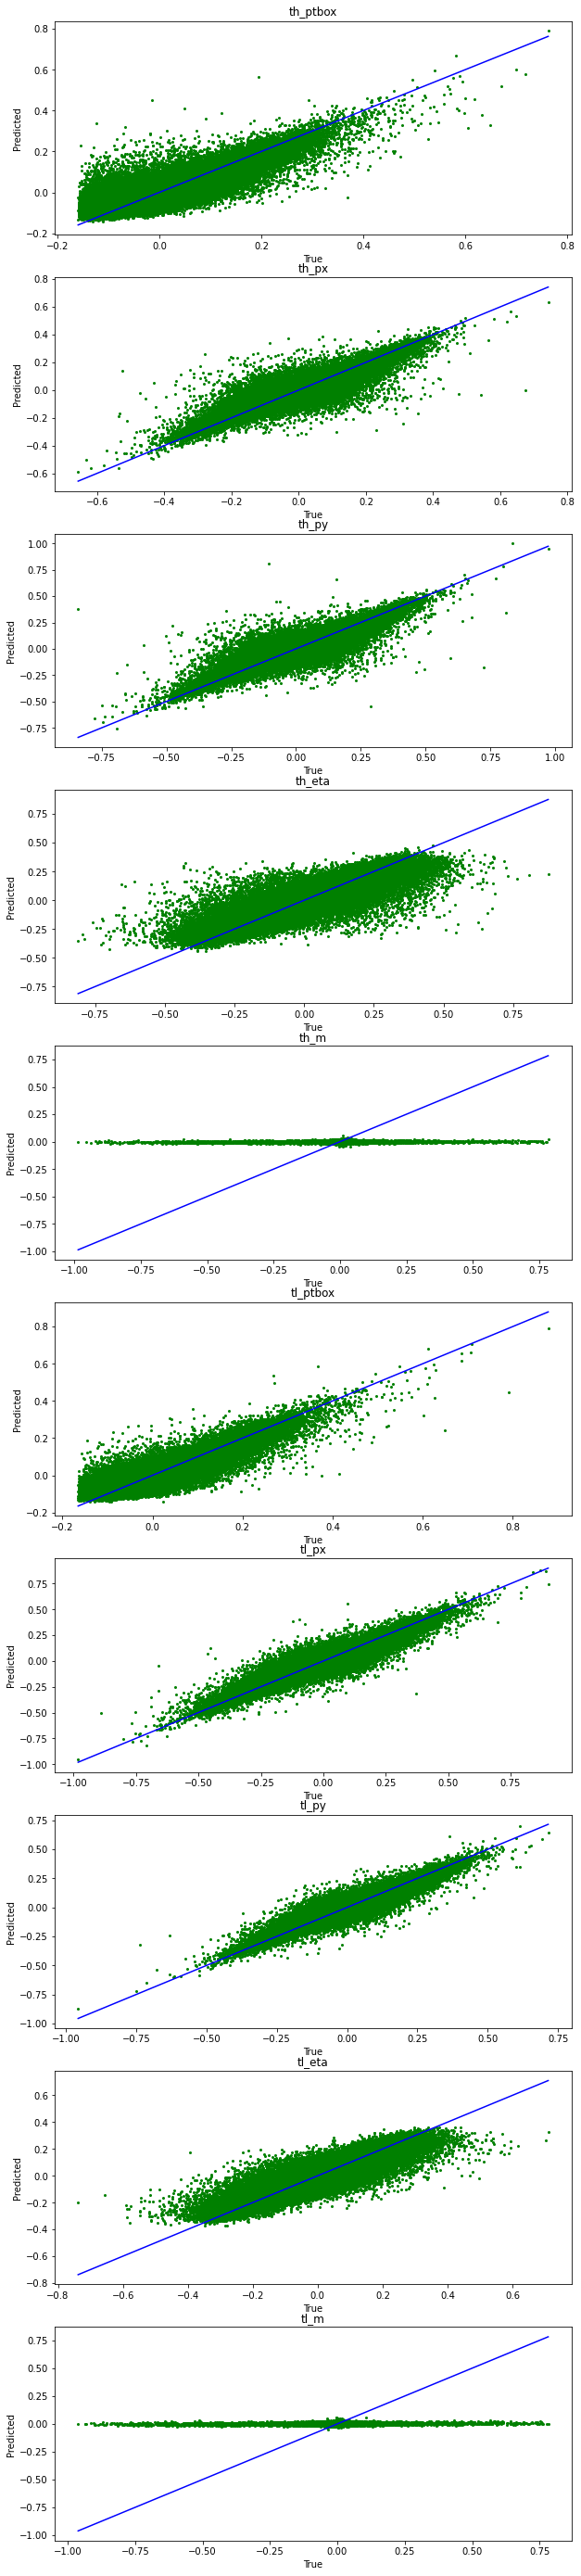

In [17]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, t_names, False)

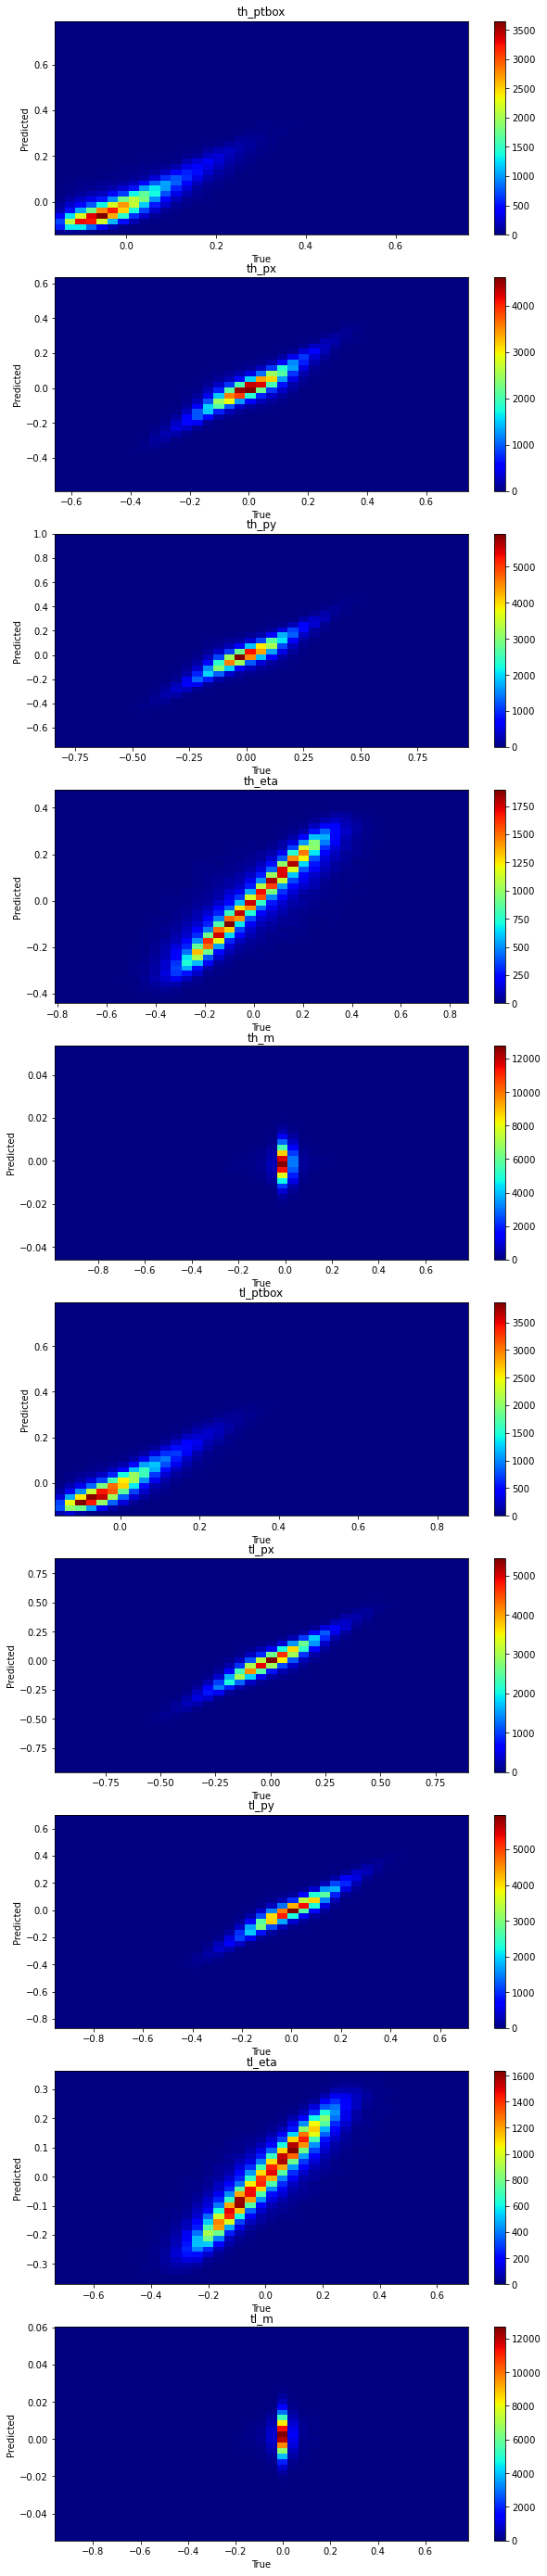

In [18]:
Analysis.predicted_vs_true_hist1(predictions_unscaled, true_unscaled, t_names, False)

 # Original scale plots

In [19]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 262.4942262633527
 
th_pt MSE :  1490.8001191607
th_eta MSE :  0.4596764457
th_phi MSE :  0.7114648791
th_m MSE :  35.7292321958
tl_pt MSE :  1143.2433655069
tl_eta MSE :  0.3708844073
tl_phi MSE :  0.4609754682
tl_m MSE :  38.5060717102
wh_pt MSE :  1574.5384839349
wh_eta MSE :  0.5160211821
wh_phi MSE :  0.7509651752
wh_m MSE :  28.5269201566
wl_pt MSE :  594.3049870610
wl_eta MSE :  0.3130096018
wl_phi MSE :  0.1885128670
wl_m MSE :  35.5332121282
bh_pt MSE :  733.2678346809
bh_eta MSE :  0.4725321760
bh_phi MSE :  1.0648423920
bh_m MSE :  35.6355356389
bl_pt MSE :  572.8325332743
bl_eta MSE :  0.4900761016
bl_phi MSE :  0.9955597134
bl_m MSE :  0.0000001701


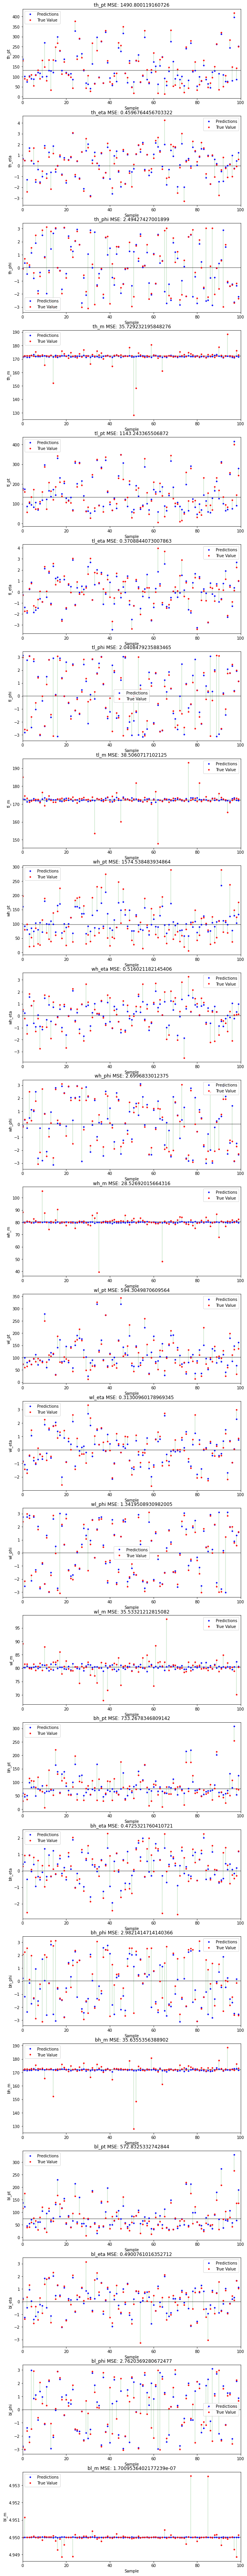

In [20]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

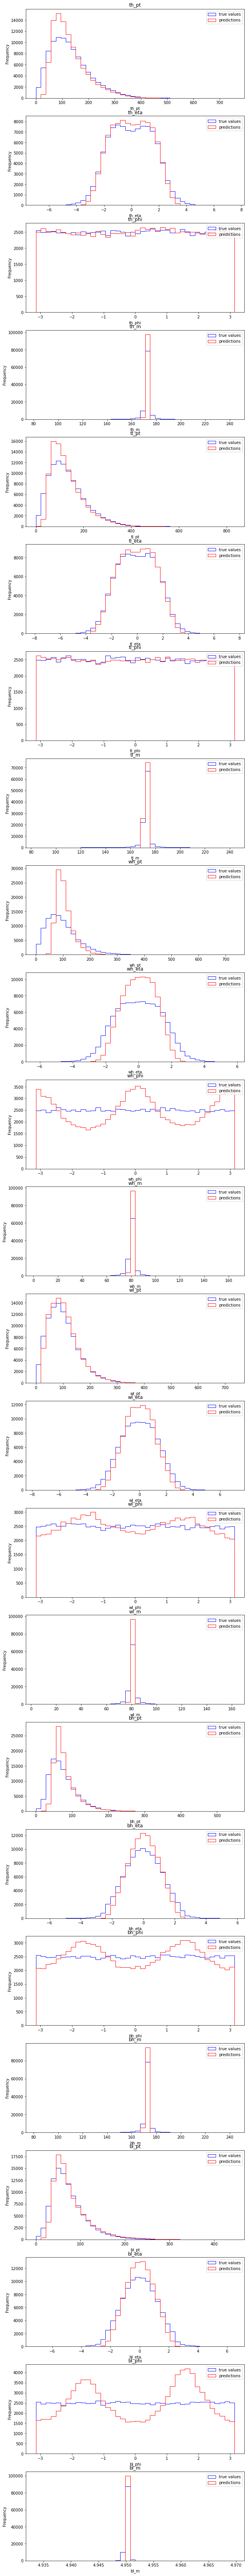

In [21]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

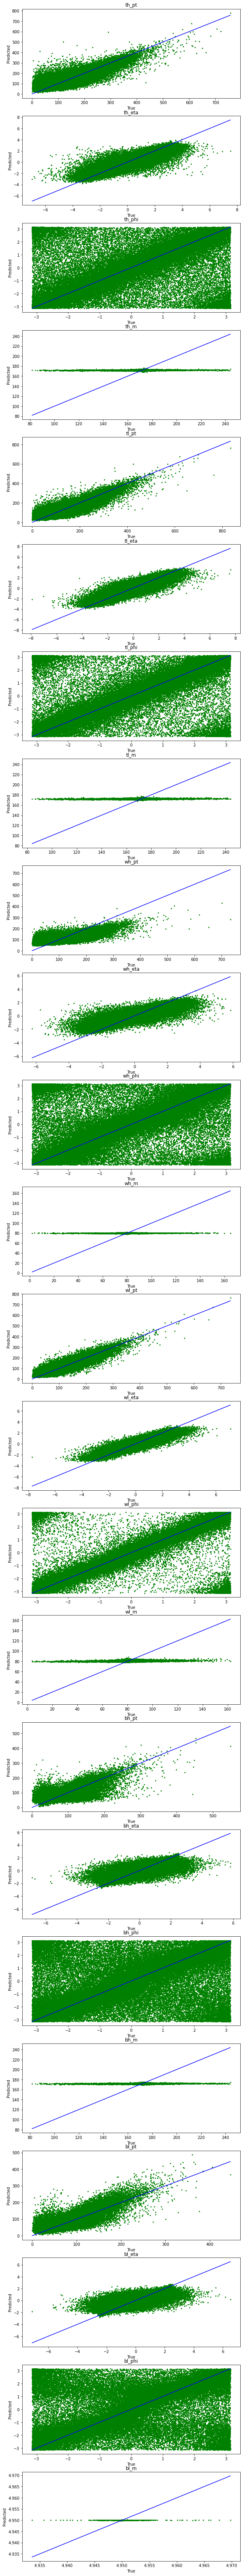

In [22]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

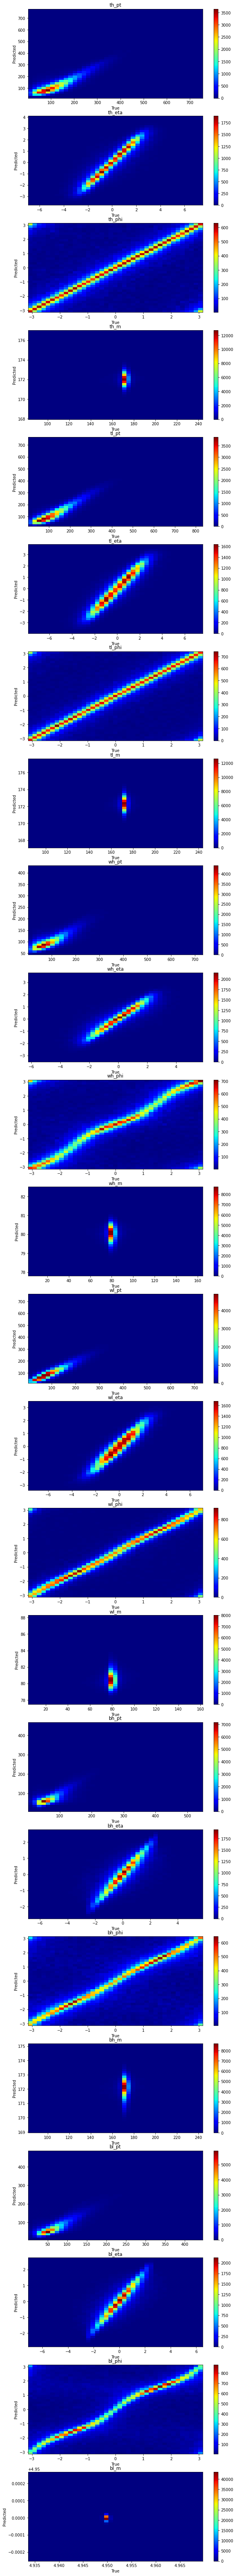

In [23]:
Analysis.predicted_vs_true_hist1(predictions_origscale, true_origscale, Y_keys, True)

# Observables

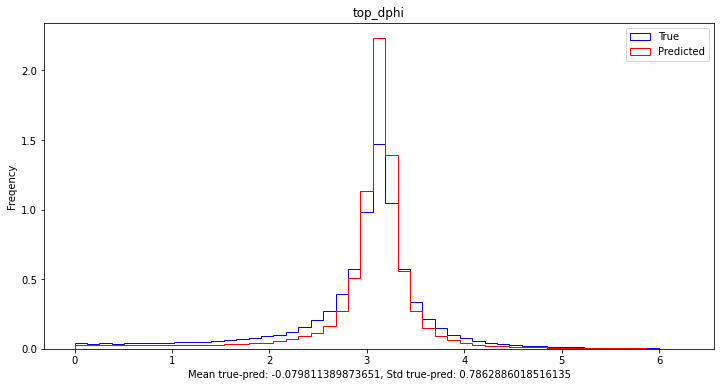

In [24]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

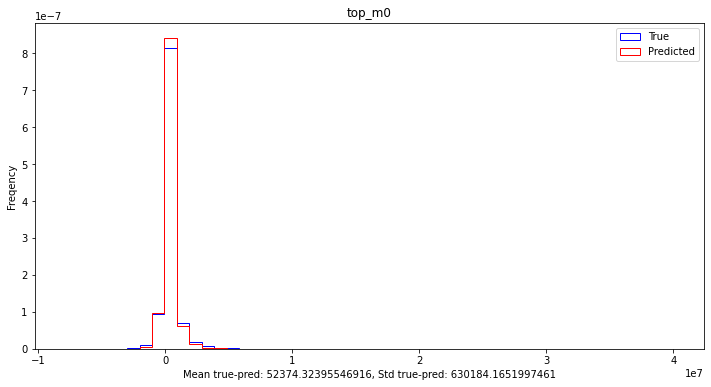

In [25]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

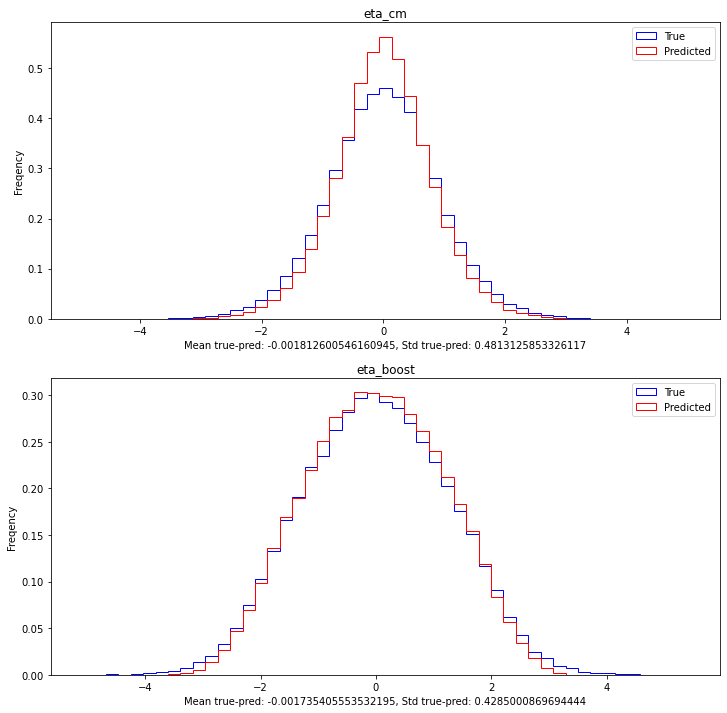

In [26]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])


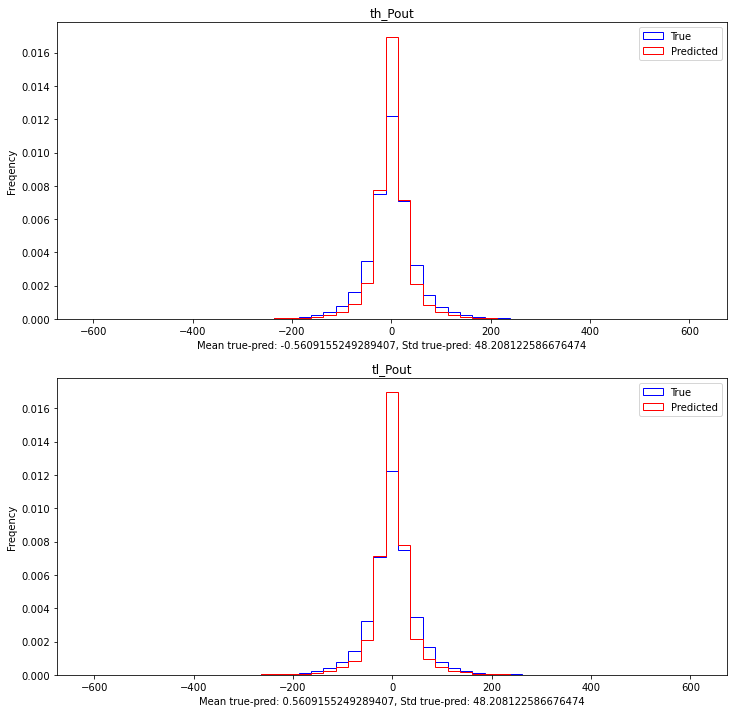

In [27]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])


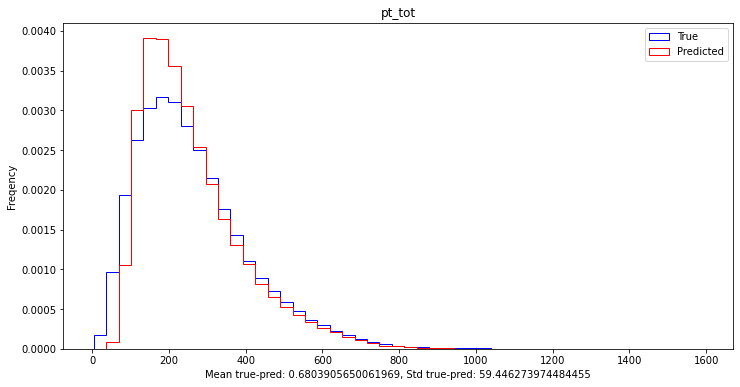

In [28]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])